#Predicting West Nile virus in mosquitoes across the city of Chicago
###Rafel Taye
###12Aug2015




##Problem and Question 
### 1. Problem: 
 First human case of West Nile virus in Chicago was discovered in 2002
  - Every week from late spring to fall, mosquito is trapped and tested for virus presence. 
  - Result of this tests influence how the city of Chicago allocate its resources in fighting malaria outbreak 

### 2. Question: 
Predict when and where different species of mosquitos will test positive for West Nile virus given training  data, weather data,location data, & spray data.
  - It is a classification problem (Wnv present or not) 


In [46]:
#read necessary datas and import useful libraries

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


##Data Preprocessing and Exploration

In [74]:
#convert weather date column to date data type
weather=pd.read_csv('weather.csv')
weather['Date'] = pd.to_datetime(weather.Date)

#replace missing values and string values with their appropriate integer values
weather.replace(to_replace=['M','  T'],value=['0','0'], inplace=True)
set(weather.Water1)
#convert object types in to floats
weather[['Tavg','Heat','StnPressure', 'WetBulb','Cool', 'PrecipTotal','AvgSpeed','SnowFall',
         'SeaLevel','Depart','Depth']] = weather[['Tavg','Heat','StnPressure', 'WetBulb','Cool','PrecipTotal',
                                                           'AvgSpeed','SnowFall','SeaLevel','Depart','Depth']].astype(float)
weather.dtypes
#weather.head(2)

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
Depart                float64
DewPoint                int64
WetBulb               float64
Heat                  float64
Cool                  float64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                 float64
Water1                 object
SnowFall              float64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
dtype: object

In [75]:
#get the month and year out of date and put it in a new column for the train data 
train=pd.read_csv('train.csv')
train['Date'] = pd.to_datetime(train.Date)
train['Month'] = train.Date.dt.month
train['Year']=train.Date.dt.year
#assign numbers for each mosquito species for train and test data 
train['Species_num'] = train.Species.map({'CULEX PIPIENS/RESTUANS':"0", 'CULEX RESTUANS':"1", 'CULEX PIPIENS':"2",
                                          'CULEX TERRITANS':"3", 'CULEX SALINARIUS':"4", 'CULEX TARSALIS':"5",'CULEX ERRATICUS':"6"})

#set weather station locations using a package called GeoPy 
from geopy.distance import vincenty
station1 = (41.995, -87.933)
station2 = (41.786, -87.752)
Station = []


for ind, _ in enumerate(train.iterrows()):
    #print Newtrain['Latitude'][ind]
    latitude_train = train['Latitude'][ind]
    longitude_train = train['Longitude'][ind]
    traploc_train = (latitude_train, longitude_train)
    
    trainstation1_dist=vincenty(traploc_train,station1).miles
    trainstation2_dist=vincenty(traploc_train,station2).miles 
    
    if trainstation1_dist < trainstation2_dist:
        Station.append(1)
    else:
        Station.append(2)
train['Station']=Station

#Merge train data with the weather data based on station and date columns 
train=pd.merge(train,weather, on=['Station','Date'],how= 'inner')


#train.head(2)
train.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
Month                              int64
Year                               int64
Species_num                       object
Station                            int64
Tmax                               int64
Tmin                               int64
Tavg                             float64
Depart                           float64
DewPoint                           int64
WetBulb                          float64
Heat                             float64
Cool                             float64
Sunrise         

In [82]:
train.Water1.head(2)

0    0
1    0
Name: Water1, dtype: object

In [76]:
#get the month and year out of date and put it in a new column for the test data 
test=pd.read_csv('test.csv')
test['Date'] = pd.to_datetime(test.Date)
test['Month'] = test.Date.dt.month
test['Year']=test.Date.dt.year
test['Species_num'] = test.Species.map({'CULEX PIPIENS/RESTUANS':"0", 'CULEX RESTUANS':"1", 'CULEX PIPIENS':"2", 'CULEX TERRITANS':"3",
                                        'CULEX SALINARIUS':"4", 'CULEX TARSALIS':"5",'CULEX ERRATICUS':"6"})


#set weather station locations using a package called GeoPy 
station1 = (41.995, -87.933)
station2 = (41.786, -87.752)
Station = []

for ind, _ in enumerate(test.iterrows()):
    #print Newtrain['Latitude'][ind]
    latitude_test = test['Latitude'][ind]
    longitude_test = test['Longitude'][ind]
    traploc_test = (latitude_test, longitude_test)
    
    teststation1_dist=vincenty(traploc_test,station1).miles
    teststation2_dist=vincenty(traploc_test,station2).miles 
    
    if teststation1_dist < teststation2_dist:
        Station.append(1)
    else:
        Station.append(2)
test['Station']=Station

#Merge test data with the weather data based on station and date columns
test=pd.merge(test,weather, on=['Station','Date'],how= 'inner')


test.dtypes
#test.head(2)

Id                                 int64
Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
Month                              int64
Year                               int64
Species_num                       object
Station                            int64
Tmax                               int64
Tmin                               int64
Tavg                             float64
Depart                           float64
DewPoint                           int64
WetBulb                          float64
Heat                             float64
Cool                             float64
Sunrise                           object
Sunset          

In [51]:
#convert spray date column to date data type
spray=pd.read_csv('spray.csv')
spray.rename(columns={'Date':'Spray_Date'}, inplace=True)
spray['Spray_Date']= pd.to_datetime(spray.Spray_Date)
spray.head(2)

,Spray_Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163


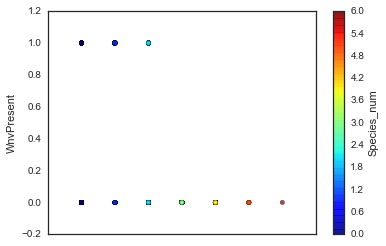

In [9]:
# graph the different species vs WnvPresent to see which ones had the virus. 
#Only three out of the seven species carry the virus ('CULEX PIPIENS/RESTUANS':0, 'CULEX RESTUANS':1, 'CULEX PIPIENS':2)
%matplotlib inline
from matplotlib.colors import ListedColormap
#cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFF00F','#00FFF0','#F00FFF'])
train.plot(kind='scatter', x='Species_num', y='WnvPresent',c='Species_num',alpha=0.7,colormap='jet') 

In [34]:
Newtrain.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,NewHeat,NewStnPressure,NewWetBulb,NewCool,NewPrecipTotal,NewAvgSpeed,NewSnowFall,NewSeaLevel,NewDepart,NewDepth
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,0,29.39,65,9,0,6.5,0,30.11,10,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,0,29.39,65,9,0,6.5,0,30.11,10,0


<IPython.core.display.Javascript object>


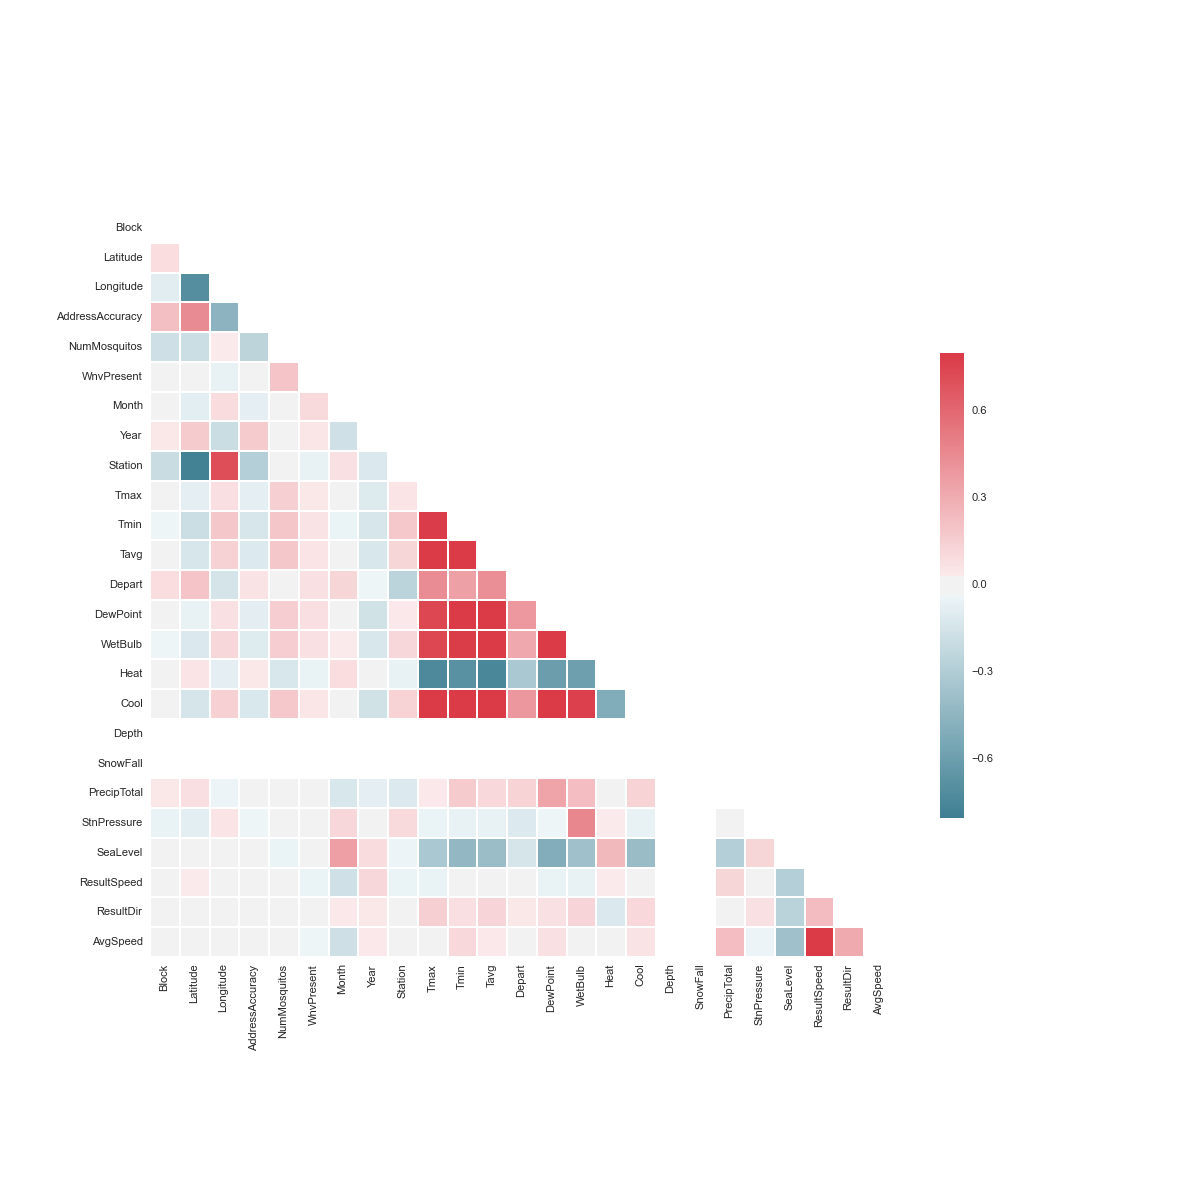

In [84]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
sns.set(style="white")
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8,square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


<IPython.core.display.Javascript object>


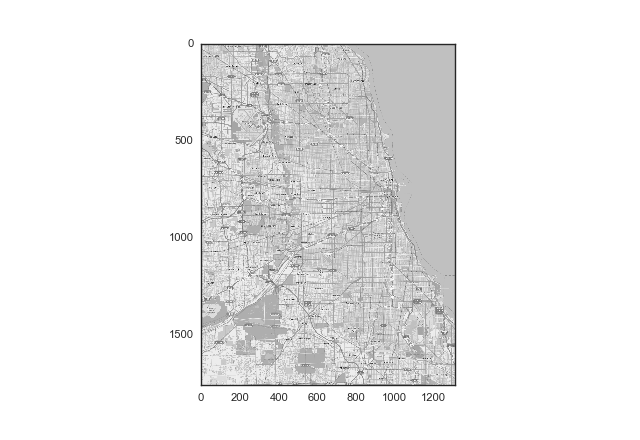

In [93]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))
plt.savefig('map.png')

In [37]:
#mean value of the WnvPresent is 0.052, This shows that there are a lot more data with out Wnv that is affecting the modeles

Newtrain['prediction'] = Newtrain.WnvPresent.mean()
Newtrain.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,NewStnPressure,NewWetBulb,NewCool,NewPrecipTotal,NewAvgSpeed,NewSnowFall,NewSeaLevel,NewDepart,NewDepth,prediction
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,29.39,65,9,0,6.5,0,30.11,10,0,0.052446
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,29.39,65,9,0,6.5,0,30.11,10,0,0.052446


In [38]:
#balance the data types between WnvPresent and not present so that models will learn the differences better

Newtrain1=Newtrain.sort('WnvPresent', ascending=False).iloc[0:1100,:]

In [39]:
Newtrain1.columns

Index([u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'Species_num',
       u'Month', u'Year', u'Station', u'Tmax', u'Tmin', u'Tavg', u'Depart',
       u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset',
       u'CodeSum', u'Depth', u'Water1', u'SnowFall', u'PrecipTotal',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed',
       u'NewTavg', u'NewHeat', u'NewStnPressure', u'NewWetBulb', u'NewCool',
       u'NewPrecipTotal', u'NewAvgSpeed', u'NewSnowFall', u'NewSeaLevel',
       u'NewDepart', u'NewDepth', u'prediction'],
      dtype='object')

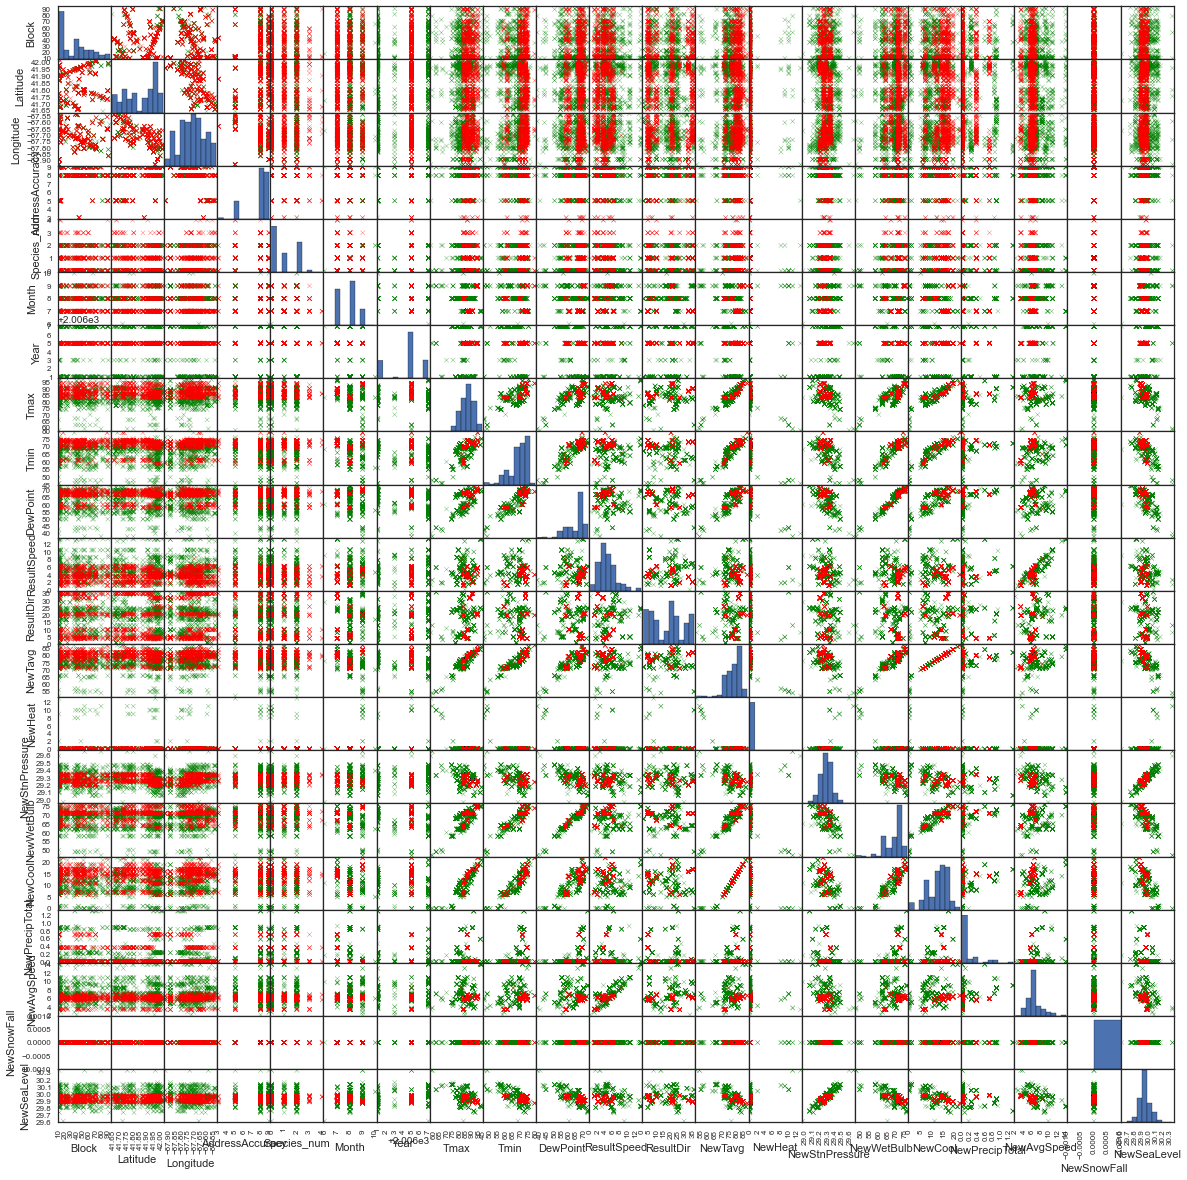

In [44]:
import matplotlib 

%matplotlib inline
feature_cols=['Block', 'Latitude', 'Longitude', 'AddressAccuracy','Species_num','Month','Year','Tmax','Tmin','DewPoint','ResultSpeed','ResultDir','NewTavg','NewHeat','NewStnPressure','NewWetBulb','NewCool','NewPrecipTotal','NewAvgSpeed','NewSnowFall','NewSeaLevel']
colors=['red','green']

#train_virus=Newtrain1[Newtrain1.WnvPresent==1]
#sns.heatmap(train_virus.corr())
#train_virus.WnvPresent.value_counts()
#feature_cols=['WnvPresent','Species_num','Month','Year']
pd.scatter_matrix(Newtrain1[feature_cols],figsize=(20,20),alpha=0.8,marker='x',c=Newtrain1.WnvPresent.apply(lambda x:colors[x]))
font = {'family' : 'normal','weight' : 'bold','size': 40}

#matplotlib.rcParams.update({'font.size': 22})

#Newtrain1.WnvPresent.value_counts().plot(kind='bar', stacked=True)
#Newtrain1.Year.value_counts().sort_index().plot()



In [45]:
Newtrain1.shape

(1100, 48)

In [46]:
Newtrain1.columns

Index([u'Date', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent', u'Species_num',
       u'Month', u'Year', u'Station', u'Tmax', u'Tmin', u'Tavg', u'Depart',
       u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset',
       u'CodeSum', u'Depth', u'Water1', u'SnowFall', u'PrecipTotal',
       u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed',
       u'NewTavg', u'NewHeat', u'NewStnPressure', u'NewWetBulb', u'NewCool',
       u'NewPrecipTotal', u'NewAvgSpeed', u'NewSnowFall', u'NewSeaLevel',
       u'NewDepart', u'NewDepth', u'prediction'],
      dtype='object')

##Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

logreg = LogisticRegression()#C=1e9
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']
X = Newtrain1[feature_cols]
y = Newtrain1.WnvPresent 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg.fit(X_train, y_train)
Wnv_pred_class = logreg.predict(X_test)

In [89]:
Wnv_pred_class

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1])

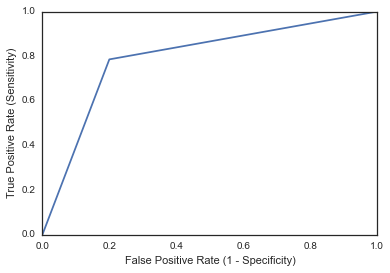

In [90]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, Wnv_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')


In [91]:
print metrics.roc_auc_score(y_test, Wnv_pred_class)


0.792857142857


In [92]:
logreg = LogisticRegression()#C=1e9
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']
X = Newtrain1[feature_cols]
y = Newtrain1.WnvPresent 
logreg.fit(X, y)
log_pred_class1 = logreg.predict(X)

In [95]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, log_pred_class1, labels=None)

array([[431, 118],
       [124, 427]])

0.780009190113


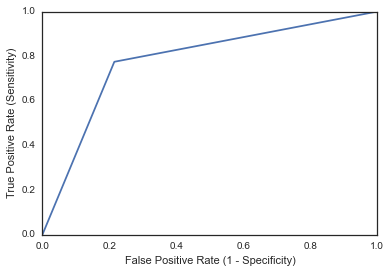

In [96]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, log_pred_class1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
print metrics.roc_auc_score(y, log_pred_class1)


In [97]:
logreg.fit(X, y)
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']

# predict wnv class for the actual testing data (not X_test)
X_oos = Newtest[feature_cols]
oos_pred = logreg.predict(X_oos)

# sample submission file indicates we need two columns: Id and predicted class
Newtest.index      # Id
oos_pred   # predicted class

# create a DataFrame that has 'id' as the index, then export to a CSV file
sub = pd.DataFrame({'id':Newtest.Id, 'WnvPresent':oos_pred}).set_index('id')
sub.to_csv('sub_log.csv')  #0.56238

predicting class using logreg using Month as a feature yielded a private leader board score of 0.56238 on Kaggle which placed me at 1157 out of 1306 teams

##Decision Tree


In [98]:
# instantiate a DecisionTreeRegressor (with random_state=1)


from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']
X = Newtrain1[feature_cols]
y=Newtrain1.WnvPresent 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
treeclass = DecisionTreeClassifier(random_state=6)
treeclass.fit(X_train, y_train)

TreeWnv_pred_class = treeclass.predict(X_test)
TreeWnv_pred_class


array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1])

0.975


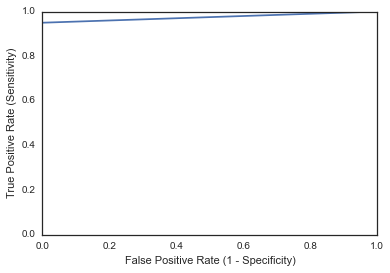

In [99]:
# plot ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, TreeWnv_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
print metrics.roc_auc_score(y_test, TreeWnv_pred_class)

In [155]:
#Cross validation feature selection

from sklearn.cross_validation import cross_val_score
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool', 
                'Year','Station','ResultSpeed', 'ResultDir','NewTavg', 
                'NewHeat','NewStnPressure','NewPrecipTotal',
                'NewAvgSpeed','NewSeaLevel','NewDepart']
X = Newtrain1[feature_cols]
y=Newtrain1.WnvPresent 
treeclass = DecisionTreeClassifier()
treeclass.fit(X,y)
TreeWnv_pred_class2 = treeclass.predict(X)
TreeWnv_pred_class2
scores=cross_val_score(treeclass,X,y,cv=15, scoring='accuracy')
scores


array([ 0.94594595,  0.97297297,  0.94594595,  0.97297297,  1.        ,
        0.97297297,  0.97297297,  0.98648649,  1.        ,  0.97260274,
        0.95890411,  0.97222222,  1.        ,  0.97222222,  0.76388889])

0.976403227779


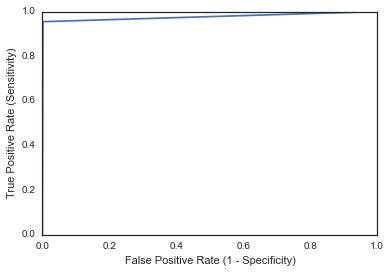

In [156]:
fpr, tpr, thresholds = metrics.roc_curve(y, TreeWnv_pred_class2)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
print metrics.roc_auc_score(y, TreeWnv_pred_class2)

In [157]:
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool', 
                'Year','Station','ResultSpeed', 'ResultDir','NewTavg', 
                'NewHeat','NewStnPressure','NewPrecipTotal',
                'NewAvgSpeed','NewSeaLevel','NewDepart']
#Newtrain1[feature_cols].describe()
pd.DataFrame({'feature':feature_cols, 'importance':treeclass.feature_importances_}).sort('importance')


,feature,importance
17,NewDepart,0.000000
1,Tmax,0.000000
2,Tmin,0.000000
4,NewTavg,0.000000
5,NewWetBulb,0.000000
14,NewPrecipTotal,0.000000
12,NewHeat,0.000000
9,ResultSpeed,0.000000
11,NewTavg,0.000000
6,NewCool,0.000013


In [158]:

treeclass.fit(X, y)
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool', 
                'Year','Station','ResultSpeed', 'ResultDir','NewTavg', 
                'NewHeat','NewStnPressure','NewPrecipTotal',
                'NewAvgSpeed','NewSeaLevel','NewDepart']


# predict wnv class for the actual testing data (not X_test)
X_oos = Newtest[feature_cols]
oos_pred = treeclass.predict(X_oos)

# sample submission file indicates we need two columns: Id and predicted class
Newtest.index      # Id
oos_pred   # predicted class

# create a DataFrame that has 'id' as the index, then export to a CSV file
sub = pd.DataFrame({'id':Newtest.Id, 'WnvPresent':oos_pred}).set_index('id')
sub.to_csv('sub_tree.csv')  #0.44068 on public leader board

##Random Forest Classifier

In [161]:
#RandomForest split, trian, test 
from sklearn.ensemble import RandomForestClassifier
rfclas = RandomForestClassifier()
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']
X=Newtrain1[feature_cols]
y=Newtrain1.WnvPresent 
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

rfclas = RandomForestClassifier(n_estimators=2000, max_features=1, max_depth=1,oob_score=True, random_state=1)
rfclas.fit(X_train, y_train)
rfWnv_pred_class=rfclas.predict(X_test)
rfWnv_pred_class

#pd.DataFrame({'feature':feature_cols, 'importance':rfclas.feature_importances_}).sort('importance')


array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [162]:
#y_pred_prob = nb.predict_proba(test_dtm)[:, 1]
#y_pred_prob
rfclas = RandomForestClassifier()
scores=cross_val_score(rfclas,X,y,cv=10, scoring='accuracy')
scores.mean()


0.95715536220123387

0.817724867725


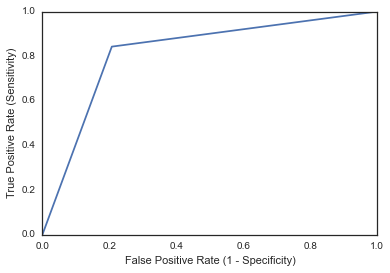

In [163]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfWnv_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
print metrics.roc_auc_score(y_test, rfWnv_pred_class)


In [181]:
rfclas = RandomForestClassifier()
feature_cols = ['Month','Tmax','Tmin','DewPoint','NewTavg','NewWetBulb','NewCool']
X=Newtrain1[feature_cols]
y=Newtrain1.WnvPresent 
rfclas = RandomForestClassifier(n_estimators=2000, max_features=1, max_depth=1,oob_score=True, random_state=1)
rfclas.fit(X,y)
rfWnv_pred_class2=rfclas.predict(X)
rfWnv_pred_class2



array([0, 0, 1, ..., 1, 1, 1])

In [179]:
pd.DataFrame({'feature':feature_cols, 'importance':rfclas.feature_importances_}).sort('importance')


,feature,importance
3,DewPoint,0.0685
1,Tmax,0.0710
9,NewAvgSpeed,0.0720
12,NewHeat,0.0730
8,NewStnPressure,0.0755
6,NewCool,0.0760
4,NewTavg,0.0780
5,NewWetBulb,0.0780
2,Tmin,0.0785
11,NewCool,0.0790


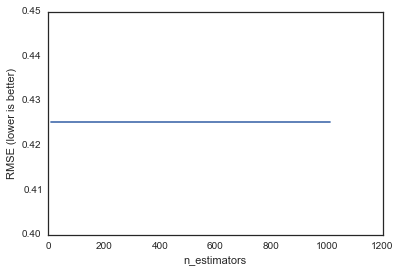

In [173]:
estimator_range = range(10,3000, 100)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    rclas = RandomForestClassifier(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfclas, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')



(0.17638165621696536, 1)

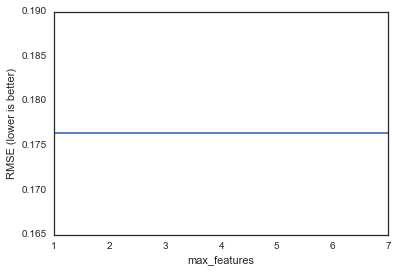

In [175]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features
for feature in feature_range:
    rfclas = RandomForestClassifier(n_estimators=2000, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfclas, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]


In [180]:

rfclas = RandomForestClassifier(n_estimators=2000, max_features=1, oob_score=True, random_state=1)
rfclas.fit(X, y)
X_oos_RF = Newtest[feature_cols]
oos_pred_RF = rfclas.predict(X_oos_RF)

sub = pd.DataFrame({'id':Newtest.Id, 'WnvPresent':oos_pred_RF}).set_index('id')
sub.to_csv('sub_rf.csv')  #0.50021

##Conclusions
 - Found out Logistic Regression was the better model (I will hold my judgment)
 - Feature engineering/selection is very important took the longest time
 - Further exploration and domain knowledge can take you far